In [2]:
import pandas as pd
import pyomo.environ as pe
import preprocessing
from optimisation import *
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
import model
import matplotlib.pyplot as plt
from scipy import stats
from tqdm import tqdm
import swifter
import pickle
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import featuretools as ft
import preprocessing
import featuretools.variable_types as vtypes
from sklearn.metrics import mean_squared_error
from math import sqrt
from vowpalwabbit import pyvw

In [9]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")

In [10]:
%%time
df_train, df_test, true_existence_expectancy_index = preprocessing.preprocessing_all(train, test, trend_features = False, trend_y = False, fill_value = -10, coeff = 0.2, num_k = 7)

CPU times: user 47.3 s, sys: 524 ms, total: 47.8 s
Wall time: 47.9 s


In [4]:
def to_vw_format(data, columns, galaxy,target=None):
    return str(target or '') + ' |features ' + " ".join([str(c).replace(' ', '_').replace(':', '').replace('|', '')+' '+str(data[c]) for c in columns ]) +" |galaxy "+ str(galaxy).replace(':', '').replace('|', '')+' '+'\n'

In [5]:
training_samples = []

columns = [c for c in df_train.columns if c not in ['y', 'galaxy']]
for _, data in tqdm(df_train.iterrows()):
    training_samples.append(to_vw_format(data, columns, data["galaxy"], (data["y"])))

validate_samples = []

for _, data in tqdm(df_train[df_train['galacticyear'] >= 1007012].iterrows()):
    validate_samples.append(to_vw_format(data, columns, data["galaxy"], (data["y"] )))

test_samples = []

for _, data in tqdm(df_test.iterrows()):
    test_samples.append(to_vw_format(data, columns, data["galaxy"]))

train_labels = df_train['y']
valid_labels = df_train[df_train['galacticyear'] >= 1007012]['y']

3865it [01:11, 53.78it/s]
804it [00:09, 86.47it/s]
890it [00:09, 95.85it/s]


In [6]:
vw = pyvw.vw( 
    loss_function='squared',
    # link='logistic',
    b=25,
    # bootstrap=20,
    q='aa',
    cubic='aaa',
    ngram=1,
#     skips=1,
#     hash='all',
#     hessian_on=True,
#     random_seed=112,
    l1=0.000001,
    # l2=0.0001,
    f='vw.log.model',
    learning_rate=0.05)

for iteration in range(100):
    for i in range(len(training_samples)):
        vw.learn(training_samples[i])
    if iteration % 10 ==0:

        train_predictions = [vw.predict(sample) for sample in training_samples]
        valid_predictions = [vw.predict(sample) for sample in validate_samples]
        print("========== step {0} ==========".format(iteration))
        print("train Loss: ", sqrt(mean_squared_error((train_labels), (train_predictions))))
        print("validate Loss: ", sqrt(mean_squared_error((valid_labels), (valid_predictions))))


train_predictions = [vw.predict(sample) for sample in training_samples]
test_predictions = [vw.predict(sample) for sample in test_samples]
vw.finish()

========== step 0 ==========
train Loss:  0.047360502941127015
validate Loss:  0.05219549406033719
========== step 10 ==========
train Loss:  0.02467039159322731
validate Loss:  0.02480950761218182
========== step 20 ==========
train Loss:  0.02137961534599489
validate Loss:  0.02399640634910886
========== step 30 ==========
train Loss:  0.017601264813261595
validate Loss:  0.014512261087061896
========== step 40 ==========
train Loss:  0.01720933111982508
validate Loss:  0.01303403538821979
========== step 50 ==========
train Loss:  0.017795459009281384
validate Loss:  0.012582666964340444
========== step 60 ==========
train Loss:  0.018440268934227882
validate Loss:  0.012471079520463021
========== step 70 ==========
train Loss:  0.018513597791278313
validate Loss:  0.012437472599771444
========== step 80 ==========
train Loss:  0.018023752340321848
validate Loss:  0.012304922905977206
========== step 90 ==========
train Loss:  0.01774637360786839
validate Loss:  0.01223504853767261


In [7]:
# df_train['linear_y'] = train_predictions
# df_test['linear_y'] = test_predictions

In [4]:
%%time
test_out, y_prob_model, y_model, rank_diviation_all = model.run_model_and_distrs(df_train, df_test, percent_val=0.15, qunity_starts=10, quantity_points_out=100, round_digits=12)


 0.0304025
[144]	valid_0's rmse: 0.0302515
[145]	valid_0's rmse: 0.0301025
[146]	valid_0's rmse: 0.0299563
[147]	valid_0's rmse: 0.0298172
[148]	valid_0's rmse: 0.0296674
[149]	valid_0's rmse: 0.0295232
[150]	valid_0's rmse: 0.0293825
[151]	valid_0's rmse: 0.029269
[152]	valid_0's rmse: 0.029108
[153]	valid_0's rmse: 0.028962
[154]	valid_0's rmse: 0.0288193
[155]	valid_0's rmse: 0.0286839
[156]	valid_0's rmse: 0.028555
[157]	valid_0's rmse: 0.028417
[158]	valid_0's rmse: 0.0283033
[159]	valid_0's rmse: 0.0281728
[160]	valid_0's rmse: 0.0280614
[161]	valid_0's rmse: 0.0279489
[162]	valid_0's rmse: 0.0278249
[163]	valid_0's rmse: 0.0277144
[164]	valid_0's rmse: 0.0275934
[165]	valid_0's rmse: 0.0274937
[166]	valid_0's rmse: 0.0273655
[167]	valid_0's rmse: 0.0272364
[168]	valid_0's rmse: 0.0271145
[169]	valid_0's rmse: 0.0269993
[170]	valid_0's rmse: 0.0268888
[171]	valid_0's rmse: 0.0267667
[172]	valid_0's rmse: 0.0266709
[173]	valid_0's rmse: 0.0265631
[174]	valid_0's rmse: 0.026461
[17

In [5]:
np.mean(rank_diviation_all)

0.1680420524691358

In [6]:
%%time
opt = galaxy_optim(test_out, y_prob_model, y_model, true_existence_expectancy_index, deviation=np.mean(rank_diviation_all))
opt.solve()
results = opt.prepare_output_file()
opt.check_optim_results()


100%|██████████| 890/890 [03:58<00:00,  3.73it/s]
# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 1782
  Number of variables: 890
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Message: Ipopt 3.13.2\x3a Optimal Solution Found
  Termination condition: optimal
  Id: 0
  Error rc: 0
  Time: 0.15784215927124023
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of s

In [7]:
df_train.columns

Index(['galacticyear', 'existenceexpectancyindex',
       'existenceexpectancyatbirth', 'Grossincomepercapita', 'IncomeIndex',
       'Expectedyearsofeducationgalacticyears',
       'Meanyearsofeducationgalacticyears', 'IntergalacticDevelopmentIndexIDI',
       'EducationIndex', 'IntergalacticDevelopmentIndexIDIRank',
       ...
       'nan__IntergalacticDevelopmentIndexIDImale',
       'const__GenderDevelopmentIndexGDI', 'varios__GenderDevelopmentIndexGDI',
       'nan__GenderDevelopmentIndexGDI', 'galaxy', 'epoch', 'ten_years', '4',
       '5', 'y'],
      dtype='object', length=355)

In [9]:
from model import split_train_val

In [10]:
X_train, X_val, y_train, y_val = split_train_val(df_train.drop(columns= ['galaxy']), df_test, 0.2)

In [11]:
import shap

gbm = lgb.LGBMRegressor(objective='rmse', max_depth=12, num_leaves=23, learning_rate=0.01, colsample_bytree=0.800, subsample=0.803, early_stopping_rounds=20,n_estimators=10000)

gbm.fit(X_train, y_train,
        eval_set=[(X_val, y_val)],
        eval_metric='RMSE',
        early_stopping_rounds=10)

d_0's rmse: 0.0169475
[2543]	valid_0's rmse: 0.0169453
[2544]	valid_0's rmse: 0.0169451
[2545]	valid_0's rmse: 0.0169457
[2546]	valid_0's rmse: 0.0169434
[2547]	valid_0's rmse: 0.0169409
[2548]	valid_0's rmse: 0.0169411
[2549]	valid_0's rmse: 0.0169387
[2550]	valid_0's rmse: 0.016939
[2551]	valid_0's rmse: 0.0169389
[2552]	valid_0's rmse: 0.0169365
[2553]	valid_0's rmse: 0.0169373
[2554]	valid_0's rmse: 0.0169346
[2555]	valid_0's rmse: 0.0169357
[2556]	valid_0's rmse: 0.0169337
[2557]	valid_0's rmse: 0.0169343
[2558]	valid_0's rmse: 0.0169361
[2559]	valid_0's rmse: 0.016938
[2560]	valid_0's rmse: 0.0169366
[2561]	valid_0's rmse: 0.0169378
[2562]	valid_0's rmse: 0.0169357
[2563]	valid_0's rmse: 0.0169359
[2564]	valid_0's rmse: 0.0169362
[2565]	valid_0's rmse: 0.016934
[2566]	valid_0's rmse: 0.0169346
[2567]	valid_0's rmse: 0.0169323
[2568]	valid_0's rmse: 0.016932
[2569]	valid_0's rmse: 0.0169295
[2570]	valid_0's rmse: 0.0169296
[2571]	valid_0's rmse: 0.0169327
[2572]	valid_0's rmse: 0.

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=0.8,
              early_stopping_rounds=20, importance_type='split',
              learning_rate=0.01, max_depth=12, min_child_samples=20,
              min_child_weight=0.001, min_split_gain=0.0, n_estimators=10000,
              n_jobs=-1, num_leaves=23, objective='rmse', random_state=None,
              reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=0.803,
              subsample_for_bin=200000, subsample_freq=0)

In [12]:
shap_values = shap.TreeExplainer(gbm).shap_values(X_train)

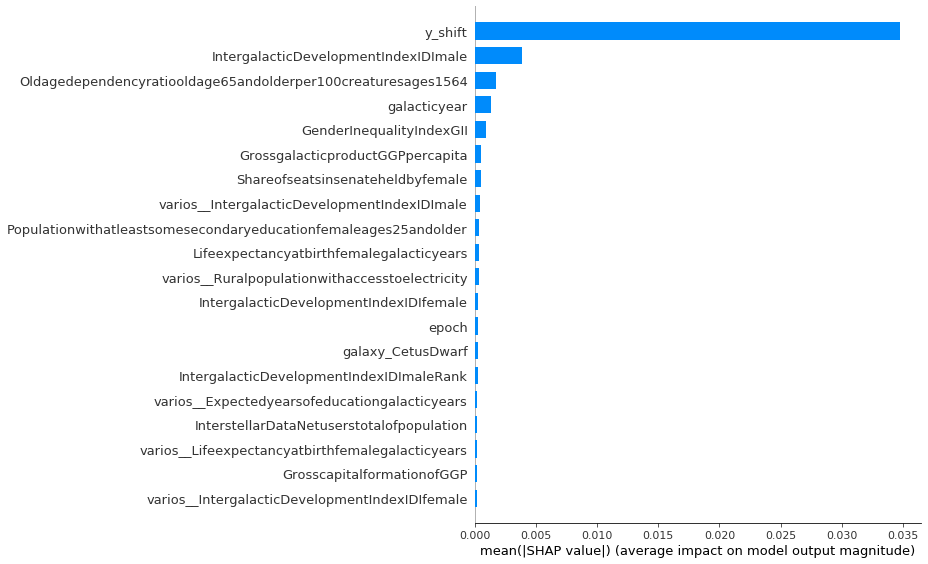

In [13]:
shap.summary_plot(shap_values, X_train, plot_type='bar')

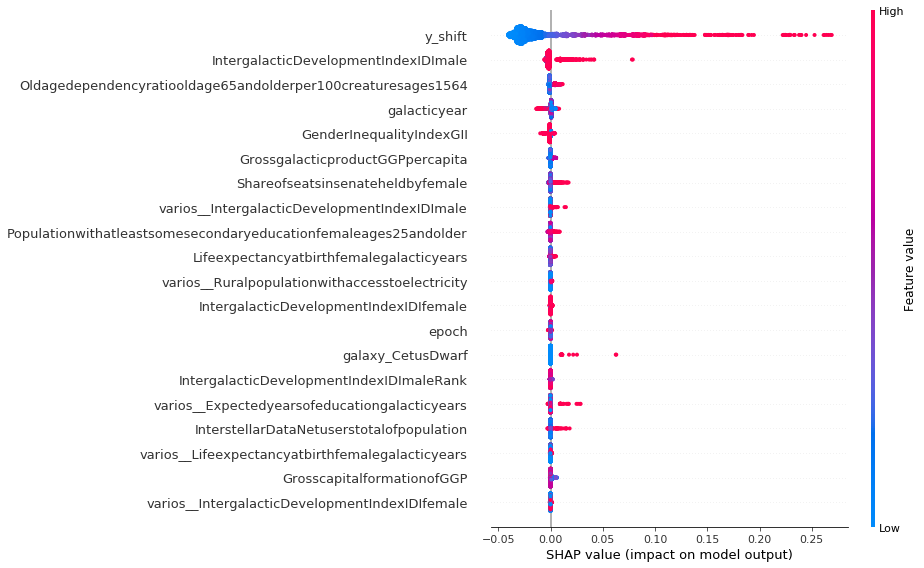

In [14]:
shap.summary_plot(shap_values, X_train)

In [48]:
import statsmodels.api as sm
lowess = sm.nonparametric.lowess

In [8]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")

In [11]:
import pandas as pd
from scipy.interpolate import interp1d
from tqdm import tqdm
import numpy as np

df_train = pd.read_csv("data/train.csv")
df_test = pd.read_csv("data/test.csv")

appended = df_train.append(df_test, ignore_index=True)

# train[train.galaxy == 'Tucana Dwarf']['Natural resource depletion']


columns = [i for i in appended.columns if i not in ['galaxy', 'galactic year', 'y']]

# columns = [i for i in ['Natural resource depletion']]
for galaxy in tqdm(appended.galaxy.unique()):
    for column in columns:
        appended_index = appended[(appended.galaxy == galaxy) & (appended[column].notnull())].index
        index_train = df_train[(appended.galaxy == galaxy) & df_train[column].isnull()].index
        index_test = df_test[(appended.galaxy == galaxy) & df_test[column].isnull()].index
        if (index_train.shape[0] + index_test.shape[0]) > 0 and (appended_index.shape[0]) > 2:
            # clf = KernelRidge(kernel='rbf', gamma=0.8)
            year = appended.loc[appended_index, 'galactic year'].to_numpy()
            column_to_predict = appended.loc[appended_index, column].to_numpy()
            model = interp1d(year, column_to_predict, kind='cubic',fill_value="extrapolate")
            df_train.loc[index_train, column] = model(df_train.loc[index_train, 'galactic year'].to_numpy().reshape(-1, 1))
            df_test.loc[index_test, column] = model(df_test.loc[index_test, 'galactic year'].to_numpy().reshape(-1, 1)) 

2%|▏         | 3/181 [00:02<02:28,  1.20it/s]


ValueError: The number of derivatives at boundaries does not match: expected 1, got 0+0

In [9]:
train[train.galaxy == 'Tucana Dwarf']['Natural resource depletion']

4       15.090820
188           NaN
411           NaN
671           NaN
741           NaN
1036    11.502083
1166          NaN
1359          NaN
1618          NaN
1667          NaN
1908     8.051527
2108          NaN
2173          NaN
2420          NaN
2582          NaN
2797    12.162163
3005          NaN
3084          NaN
3229          NaN
3252          NaN
3331    12.201884
3463    13.689455
3539    12.730856
3644    11.637150
3734     3.353426
3845    10.128919
Name: Natural resource depletion, dtype: float64

In [10]:
df_train[df_train.galaxy == 'Tucana Dwarf']['Natural resource depletion']

4       15.090820
188     14.373937
411     13.656334
671     12.938730
741     12.220407
1036    11.502083
1166    10.812524
1359    10.122966
1618     9.432717
1667     8.742467
1908     8.051527
2108     8.872669
2173     9.694632
2420    10.516595
2582    11.339379
2797    12.162163
3005    12.170101
3084    12.178039
3229    12.185984
3252    12.193930
3331    12.201884
3463    13.689455
3539    12.730856
3644    11.637150
3734     3.353426
3845    10.128919
Name: Natural resource depletion, dtype: float64

In [23]:
train.columns

Index(['galactic year', 'galaxy', 'existence expectancy index',
       'existence expectancy at birth', 'Gross income per capita',
       'Income Index', 'Expected years of education (galactic years)',
       'Mean years of education (galactic years)',
       'Intergalactic Development Index (IDI)', 'Education Index',
       'Intergalactic Development Index (IDI), Rank',
       'Population using at least basic drinking-water services (%)',
       'Population using at least basic sanitation services (%)',
       'Gross capital formation (% of GGP)', 'Population, total (millions)',
       'Population, urban (%)',
       'Mortality rate, under-five (per 1,000 live births)',
       'Mortality rate, infant (per 1,000 live births)',
       'Old age dependency ratio (old age (65 and older) per 100 creatures (ages 15-64))',
       'Population, ages 15–64 (millions)',
       'Population, ages 65 and older (millions)',
       'Life expectancy at birth, male (galactic years)',
       'Life expect

In [1]:
df_train = pd.read_csv("data/train.csv")
df_test = pd.read_csv("data/test.csv")

NameError: name 'pd' is not defined

In [61]:
appended = df_train.append(df_test)

In [67]:
appended = df_train.append(df_test, ignore_index=True)


columns = [i for i in appended.columns if i not in ['galaxy', 'galactic year', 'y']]
for galaxy in tqdm(appended.galaxy.unique()):
    for column in columns:
        appended_index = appended[(appended.galaxy == galaxy) & (appended[column].notnull())].index
        index_train = df_train[df_train[column].isnull()].index
        index_test = df_test[df_test[column].isnull()].index
        if (index_train.shape[0] + index_test.shape[0]) > 0 and (appended_index.shape[0]) > 0:
            clf = KernelRidge(kernel='rbf', gamma=0.8)
            year = appended.loc[appended_index, 'galactic year'].to_numpy().reshape(-1, 1)
            column_to_predict = appended.loc[appended_index, column].to_numpy().reshape(-1, 1)
            model = clf.fit(year, column_to_predict)

            df_train.loc[index_train, column] = model.predict(df_train.loc[index_train, 'galactic year'].to_numpy().reshape(-1, 1))
            df_test.loc[index_test, column] = model.predict(df_test.loc[index_test, 'galactic year'].to_numpy().reshape(-1, 1)) 

0%|          | 0/181 [00:00<?, ?it/s]


ValueError: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required by check_pairwise_arrays.

In [42]:
train['Population using at least basic drinking-water services (%)'][train['galaxy'] == 'UGCA 438 (ESO 407-018)']

59     NaN
299    NaN
368    NaN
603    NaN
729    NaN
1076   NaN
1105   NaN
1375   NaN
1482   NaN
1666   NaN
1815   NaN
2052   NaN
2207   NaN
2497   NaN
2538   NaN
2734   NaN
2896   NaN
3571   NaN
3612   NaN
3741   NaN
3812   NaN
Name: Population using at least basic drinking-water services (%), dtype: float64

In [40]:
train[train['Population using at least basic drinking-water services (%)'].isnull()]

# [train['galaxy'] == 'Andromeda I']

,galactic year,galaxy,existence expectancy index,existence expectancy at birth,Gross income per capita,Income Index,Expected years of education (galactic years),Mean years of education (galactic years),Intergalactic Development Index (IDI),Education Index,...,"Intergalactic Development Index (IDI), female","Intergalactic Development Index (IDI), male",Gender Development Index (GDI),"Intergalactic Development Index (IDI), female, Rank","Intergalactic Development Index (IDI), male, Rank",Adjusted net savings,"Creature Immunodeficiency Disease prevalence, adult (% ages 15-49), total",Private galaxy capital flows (% of GGP),Gender Inequality Index (GII),y
59,990025,UGCA 438 (ESO 407-018),0.972316,72.580008,13969.493658,0.615335,15.006506,11.227895,0.831361,0.869811,...,0.809723,0.831942,0.937322,142.296069,144.339987,NaN,NaN,30.671614,NaN,0.073286
144,990025,NGC 5253,NaN,NaN,20429.375702,0.633556,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.045115
299,991020,UGCA 438 (ESO 407-018),0.807131,78.100369,21162.130559,0.486831,15.006506,11.227895,0.831361,0.869811,...,0.809723,0.831942,0.937322,142.296069,144.339987,NaN,NaN,30.671614,NaN,0.073308
368,992016,UGCA 438 (ESO 407-018),0.813151,79.227378,21689.282383,0.652129,15.006506,11.227895,0.831361,0.869811,...,0.809723,0.831942,0.937322,142.296069,144.339987,NaN,NaN,30.671614,NaN,0.073258
603,993012,UGCA 438 (ESO 407-018),0.873985,80.386068,1056.143264,0.477322,15.006506,11.227895,0.831361,0.869811,...,0.809723,0.831942,0.937322,142.296069,144.339987,NaN,NaN,30.671614,NaN,0.072964
729,994009,UGCA 438 (ESO 407-018),0.896877,79.154605,16911.513013,0.733026,15.006506,11.227895,0.831361,0.869811,...,0.809723,0.831942,0.937322,142.296069,144.339987,NaN,NaN,30.671614,NaN,0.072657
1076,995006,UGCA 438 (ESO 407-018),0.924502,83.827722,36741.296020,0.754176,15.053829,11.227895,0.831361,0.869811,...,0.809723,0.831942,0.937322,142.296069,144.339987,NaN,NaN,28.095754,NaN,0.072409
1105,996004,UGCA 438 (ESO 407-018),0.952535,75.047626,20880.573828,0.695752,13.670059,11.227895,0.831361,0.869811,...,0.809723,0.831942,0.937322,142.296069,144.339987,NaN,NaN,30.671614,NaN,0.072113
1375,997002,UGCA 438 (ESO 407-018),0.948357,81.601049,21462.647269,0.716014,15.452055,11.227895,0.831361,0.869811,...,0.809723,0.831942,0.937322,142.296069,144.339987,NaN,NaN,30.671614,NaN,0.071836
1482,998001,UGCA 438 (ESO 407-018),0.966796,80.499962,24971.494272,0.823047,15.352280,11.227895,0.831361,0.869811,...,0.809723,0.831942,0.937322,142.296069,144.339987,NaN,NaN,30.671614,NaN,0.071473


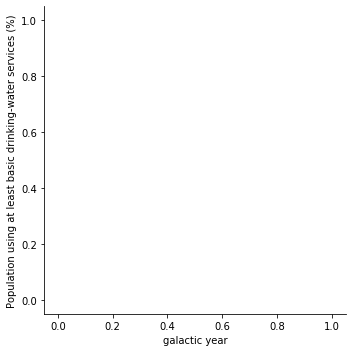

In [37]:
sns.lmplot(x='galactic year', y='Population using at least basic drinking-water services (%)', data=train[train['galaxy'] == 'Estimated gross galactic income per capita, female'])